# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [332]:
from collections import defaultdict
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
from plotly import tools
plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [333]:
# general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [334]:
# feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [335]:
# display( azdias.head(1), feat_info.head(1) ) 

In [336]:
# display( azdias.columns,  feat_info.columns ) 

In [337]:
# display( azdias.describe(),  feat_info.describe() ) 

In [338]:
# display( feat_info.missing_or_unknown.value_counts(), azdias.PLZ8_ANTG2.value_counts() )  # exploring value counts

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

> 1. Look at types of values used for missing data in the features summary dataframe
> 2. Convert missing values to NaNs

In [339]:
# reference: Udacity mentor code: https://knowledge.udacity.com/questions/98491
def get_missing_and_replace(df):
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = (feat_info.loc[index,'missing_or_unknown']).strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item]) 
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

In [340]:
get_missing_and_replace(azdias)

In [341]:
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

> 1. Identify missing data in columns

a. Null Data

In [342]:
# reference kaggle: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data
total_nulls = azdias.isnull().sum().sort_values(ascending=False)
percent_nulls = (azdias.isnull().sum()/azdias.isnull().count()).sort_values(ascending=False)
nulls_df = pd.concat([total_nulls, round(percent_nulls*100,2)], axis=1, keys=['Total Nulls', 'Percent Nulls'])
nulls_df.head(7) 

,Total Nulls,Percent Nulls
TITEL_KZ,889061,100
AGER_TYP,685843,77
KK_KUNDENTYP,584612,66
KBA05_BAUMAX,476524,53
GEBURTSJAHR,392318,44
ALTER_HH,310267,35
REGIOTYP,158064,18


* Drop columns with over 20% missing values

In [343]:
above_twenty_missing_cols = nulls_df.index.tolist()[:6] # we will drop these

In [344]:
azdias.drop(above_twenty_missing_cols, axis='columns', inplace=True) # these were above 20% missing

b. Non-Null Data

In [345]:
# reference kaggle: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data
total_non_nulls = azdias.notnull().sum().sort_values(ascending=False)
percent_non_nulls = ( azdias.notnull().sum()/azdias.notnull().count() ).sort_values(ascending=False)
non_nulls_df = pd.concat([total_non_nulls, round(percent_non_nulls*100,2)], axis=1, keys=['Total Non Nulls', 'Percent Non Nulls'])
non_nulls_df.head(15)

,Total Non Nulls,Percent Non Nulls
ZABEOTYP,891221,100
SEMIO_TRADV,891221,100
SEMIO_KAEM,891221,100
SEMIO_DOM,891221,100
SEMIO_KRIT,891221,100
SEMIO_RAT,891221,100
SEMIO_KULT,891221,100
SEMIO_ERL,891221,100
SEMIO_LUST,891221,100
SEMIO_VERT,891221,100


> 2. Plot distribution

a. Null data

In [346]:
x = nulls_df.index
y = nulls_df['Total Nulls']

plotly.offline.iplot({
    "data": [go.Bar(x=x, y=y )],
        "layout": go.Layout(title="Nulls Data Plot")
})

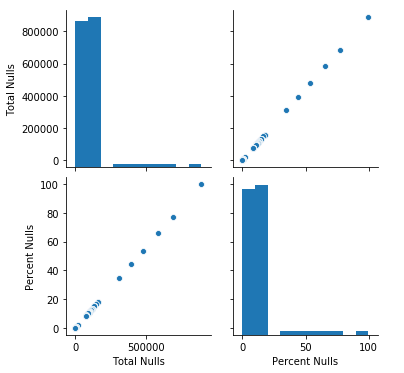

In [347]:
sns.pairplot(nulls_df)

b. Non-Null data

In [348]:
x = non_nulls_df.index
y = non_nulls_df['Total Non Nulls']

plotly.offline.iplot({
    "data": [go.Bar(x=x, y=y )],
        "layout": go.Layout(title="Non-Nulls Data Plot")
})

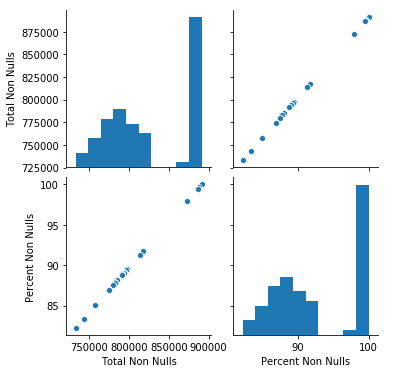

In [349]:
sns.pairplot(non_nulls_df)

#### Discussion 1.1.2: Assess Missing Data in Each Column

> **Are there any patterns in missing values?**

   When plotting the null or missing data, the first column you notice is the KK_KUNDENTYP which exceeds 550,000 nulls which could be viewed as an outlier as no other column exceeds even 200,000 in missing values. The interesting part is that the word “Kunden” means “Customer” in English which means that column was the “Customer Type” which would seem to be very valuable however, with exceeding null values, this will not be helpful in our analysis. The Data Dictionary describes this column as “customer pattern over 12 months”. 

   One pattern I found was noticing that the next set of large missing value columns were prefixed with the same prefix. Which could mean that these two "groups" just didn't generate enough data at the time of the data collection process. 
      
   The first group were prefixed with 'KBA05'. Columns “KBA05_ANTG1','KBA05_ANTG2, KBA05_GBZ” were next in columns with most missing or nulls data. According to the Data Dictionary these columns are categorized in the RR3 micro-cell features, where ANTG1 is the number of 1-2 family houses in microcell, ANTG2 is 3-5 family houses, and GBZ are number of buildings in the microcell.

   The next biggest group of missing values were prefixed with 'PLZ8' and also included values come from group 'REGIOTYP'. The REGIOTYP is part of a region feature for neighborhood typology which would also seem like valuable data. The 'PLZ8' prefixed data refer to “macro-cell features” like number of 1-2 family, 3-5 family houses, or number of buildings in this region. 

> **Which columns were removed from the dataset?**
    
   The TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH we dropped. They had missing values over 20%.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

1. How much data is missing in each row of the dataset?

* The threshold per row for missing values will be between 9 and 32 
* The required comparison will be the 2 subsets of rows ( above and under the threshold) 
* Note from Udacity Mentor: Compare between these subsets in only at least 5 columns that have zero missing data or few missing data

In [350]:
missing_values_threshold = azdias.isnull().sum(axis=1)

In [351]:
below_threshold_value = azdias[missing_values_threshold <= 20]
above_threshold_value = azdias[missing_values_threshold > 20]

1. Compare the distribution five columns few missing values, between the two subsets.
> Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.

In [352]:
above_threshold_value.shape, below_threshold_value.shape

((93795, 79), (797426, 79))

* Assess which columns you'd like to use for countplot()

* Above threshold countplots

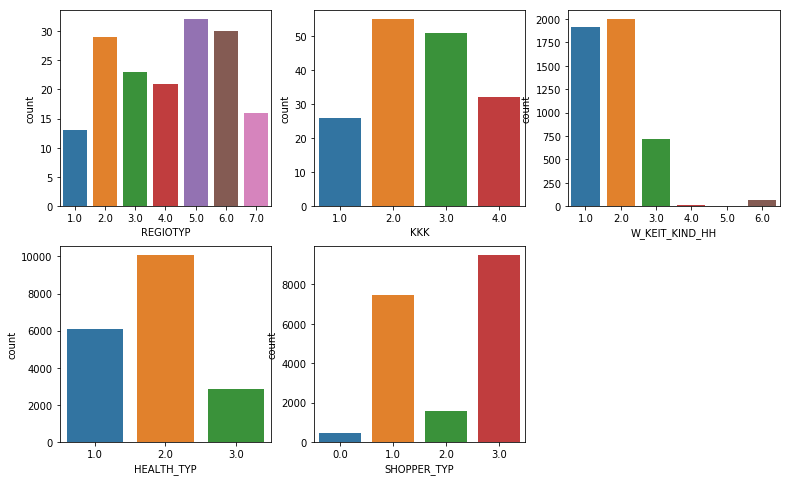

In [353]:
df = above_threshold_value 

x = ['REGIOTYP', 'KKK', 'W_KEIT_KIND_HH', 'HEALTH_TYP', 'SHOPPER_TYP']

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(left=1, bottom=1, right=2, top=2)

fig.add_subplot(231)
sns.countplot(data=df, x=x[0])

fig.add_subplot(2, 3, 2)
sns.countplot(data=df, x=x[1])

fig.add_subplot(233)
sns.countplot(data=df, x=x[2])

fig.add_subplot(2,3,4)
sns.countplot(data=df, x=x[3])

fig.add_subplot(235)
sns.countplot(data=df, x= x[4])

plt.show()

* Below threshold countplots

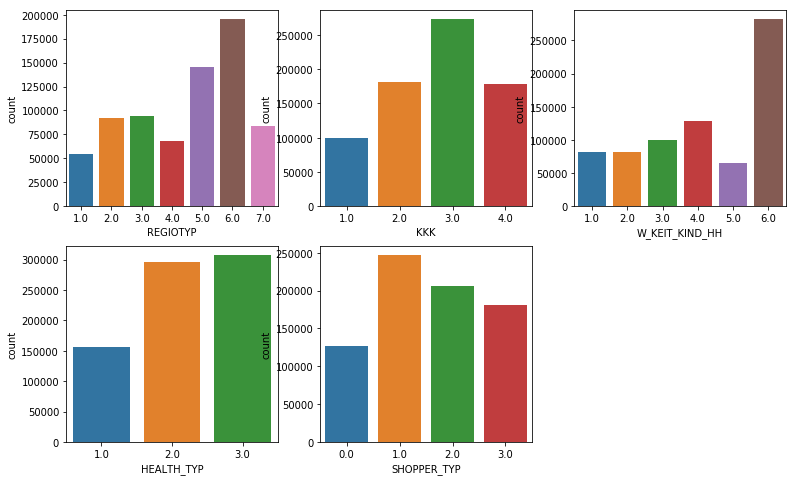

In [354]:
df = below_threshold_value 

x = ['REGIOTYP', 'KKK', 'W_KEIT_KIND_HH', 'HEALTH_TYP', 'SHOPPER_TYP']

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(left=1, bottom=1, right=2, top=2)

fig.add_subplot(231)
sns.countplot(data=df, x=x[0])

fig.add_subplot(2, 3, 2)
sns.countplot(data=df, x=x[1])

fig.add_subplot(233)
sns.countplot(data=df, x=x[2])

fig.add_subplot(2,3,4)
sns.countplot(data=df, x=x[3])

fig.add_subplot(235)
sns.countplot(data=df, x= x[4])

plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Through observations from exploratory data analysis, the data was split into two groups, below 20 missing values or null values and more than 20 missing or null values. Through plotting these two groups, I found that the above threshold value were missing more values but, didn't seem to have a major influence except for the "Kids per Household" or "W_KEIT_KIND_HH" column.

* As per instructions I will continue with the analysis with group that had least missing values labeled as `below_threshold_value`

In [355]:
azdias_threshold = below_threshold_value.copy()

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will:
   * **1. Perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each.**
   * **2. Then, in the last part, you will create a new data frame with only the selected and engineered columns.**
   
1. How many features are there of each data type?

In [356]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

1. Keep and one hot encode OST_WEST_KZ

In [357]:
feat_info[ (feat_info['type']=='categorical') & (feat_info['information_level']!='person') ]  

,attribute,information_level,type,missing_or_unknown
47,KK_KUNDENTYP,household,categorical,[-1]
52,GEBAEUDETYP,building,categorical,"[-1,0]"
55,OST_WEST_KZ,building,categorical,[-1]
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"[-1,X]"
58,CAMEO_DEU_2015,microcell_rr4,categorical,[XX]


In [358]:
bi_multi_list = feat_info[ (feat_info['type']=='categorical') & (feat_info['information_level']!='person') ].attribute  

In [359]:
drop_multi_cols = bi_multi_list.tolist()[1:2] + bi_multi_list.tolist()[3:]

In [360]:
drop_multi_cols

['GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

In [361]:
azdias_threshold.drop(drop_multi_cols, axis='columns', inplace=True) 

#### One hot encode 
1. encode column OST_WEST_KZ keeping NaNs for `unknown`

> This is the one binary variable that takes non-numeric values so we will use pandas get_dummies() to encode.
- -1: unknown = NaN (converted to NaNs in previous section)
- O: East (GDR) = 1
- W: West (FRG) = 2

In [362]:
azdias_threshold['OST_WEST_KZ'] = pd.get_dummies(azdias_threshold['OST_WEST_KZ'])

In [363]:
azdias_threshold['OST_WEST_KZ'].value_counts()

0    628987
1    168439
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

Assess categorical variables: 
1. Binary: "person, building"
2. Multi-level: "building, microcell_rr4"

Assessing categorical variables I noticed the "information-level" variables that had more than three values were "household, microcell_rr4, and building". 

The instructions referred to one binary variable with non-numeric values which was OST_WEST_KZ while I also found CAMEO_DEU_2015 non-numeric as well. I only encoded OST_WEST_KZ because in the next section we are to encode CAMEO_INTL_2015 which I thought could mean we'd have CAMEO_ related data from that column so I felt comfortable dropping CAMEO_DEU_2015 keeping CAMEO_INTL_2015. 

The others in the multi-level category like, CAMEO_DEUG_2015 and GEBAEUDETYP were dropped. I did not feel GEBAEUDETYP column was that relevant which was type of building so that reasoning there.

The engineering process was to use pandas get_dummies() for the encoding, sklearn has OneHotEncoder() which is not as quick and easy as pandas so I went with pandas. In order to drop the columns with three or more values, I filtered the data using pandas with `feat_info` dataframe, then converted those column names to a list, which was then passed into the dropna() pandas function for the `azdias` dataframe to be removed.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:

- **"PRAEGENDE_JUGENDJAHRE"** combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

1. Create two new variables: 
    a. Investigate variables: 
    - decade_numeric: {'40s':1, '50s':2, '60s':3, '70s':4, '80s':5, '90s':6)
    - movement_binary: {'Mainstream':1, 'Avantgarde': 2}


- **"CAMEO_INTL_2015"** combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (_which, for the purposes of this project, is equivalent to just treating them as their raw numeric values_).

1. Create two new variables: *_NOTE: we can also just split values and leave as is_
    a. Investigate variables: 
    - wealth, numeric: {'Wealthy':1, 'Prosperous':2, 'Comfortable':3, Less Affluent':4, 'Poorer Households':5 }
    - life stage, binary: {'Pre-Family':1, 'Young Couples': 2, 'Families With School':3,'Older Families': 4, 'Elders': 5}
    

##### Custom encode for "Mixed" Categorical Features
1. convert two variables for PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
2. Build helper functions

In [364]:
def get_helper(x, mapping):
    new_x = np.nan
    for k, v in mapping.items():
        if x == k:
            new_x = v
        continue
    return new_x

a. Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [365]:
def get_decade(x):
    decade_numeric = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    return get_helper(x, decade_numeric)

In [366]:
def get_movement(x):
    movement_binary = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
    return get_helper(x, movement_binary)

In [367]:
azdias_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_threshold.loc[:, 'PRAEGENDE_JUGENDJAHRE'].apply(get_decade)

In [368]:
azdias_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_threshold.loc[:,'PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

b. Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [369]:
azdias_threshold.CAMEO_INTL_2015.describe()

count     791423
unique        21
top           51
freq      133673
Name: CAMEO_INTL_2015, dtype: object

In [370]:
def get_wealth(x):
    new_x = str(x)[0]
    return new_x if new_x != 'n' else np.nan

In [371]:
def get_lifestage(x):
    new_x = str(x)[1]
    return new_x if new_x != 'a' else np.nan

In [372]:
azdias_threshold['CAMEO_INTL_2015_WEALTH'] = azdias_threshold.loc[:,'CAMEO_INTL_2015'].apply(get_wealth)

In [373]:
azdias_threshold['CAMEO_INTL_2015_LIFESTAGE'] = azdias_threshold.loc[:,'CAMEO_INTL_2015'].apply(get_lifestage)

##### Here we will drop the CAMEO_INTL and  columns since we've split these into two encoded variable columns

In [374]:
mixed_encoded_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

In [375]:
azdias_threshold.drop(mixed_encoded_cols, axis='columns', inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

1. For the PRAEGENDE_JUGENDJAHRE column I used a helper function to map the numeric values to the variable types.  

2. For the CAMEO_INTL_2015 column I decided to just split the value into two numeric values, since that was the easiest using the str() method in python with indexing.
3. Finally, we dropped the original columns to help with analysis later on.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

##### Sanity check on our final dataframe which we will use in the next section of our analysis
1. Re-check our percentage of nulls/ missing values to ensure they are lower
2. Create a copy of our new dataframe 

In [376]:
azdias_clean = azdias_threshold.copy()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [377]:
def clean_data(df):
    """
    Perform feature missing value replacement, encoding, and feature engineering for demographics data
    INPUT: Demographics DataFrame
    OUTPUT: Cleaned Demographics DataFrame
    """    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')
    
    ########### DROP COLUMNS IN FEAT_INFO NOT IN DF ###################
    feat_info = feat_info.drop(feat_info.index[[0,11,14,15,16,17,18,21,22,38,39,40,41,43,44,45,47,48,49,50,
                                                51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,
                                                71,72,73,74,75,76,77,78,79,80,81,82,83,84]])
    
    ########### REPLACE MISSING DATA COLUMNS WITH NaNs ################
    # reference: Udacity mentor code: https://knowledge.udacity.com/questions/98491
    def get_missing_and_replace(df):
        feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')
        for index in feat_info.index:
            feat_info.loc[index,'missing_or_unknown'] = (feat_info.loc[index,'missing_or_unknown']).strip('[]').split(',')
            for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
                try:
                    feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item]) 
                except:
                    continue
            df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

    get_missing_and_replace(df)

    ########### DROP MISSING DATA COLUMNS ABOVE THRESHOLD 20% ################

    # reference kaggle: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data
    total_nulls = df.isnull().sum().sort_values(ascending=False)
    percent_nulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    nulls_df = pd.concat([total_nulls, round(percent_nulls*100,2)], axis=1, keys=['Total Nulls', 'Percent Nulls'])
    ####### end reference 

    above_twenty_missing_cols = nulls_df.index.tolist()[:6] 
    df.drop(above_twenty_missing_cols, axis='columns', inplace=True) 

    missing_values_threshold = df.isnull().sum(axis=1)

    ########### DROP MISSING DATA ROWS ABOVE THRESHOLD 20 ################
    """
    Divide data into two groups of missing row values to determine a threshold
    Two groups will be above and below the threshold of 20
    Then drop columns above the threshold
    """
    missing_values_threshold = df.isnull().sum(axis=1)
    below_threshold_value = df[missing_values_threshold <= 20]
    above_threshold_value = df[missing_values_threshold > 20]

    ########### CREATE NEW DF OF BELOW THRESHOLD MISSING VALUES ################
    df_threshold = below_threshold_value.copy()

    """
    Drop columns with "multi-level" values
    """
    bi_multi_level_df = feat_info[ (feat_info['type']=='categorical') & (feat_info['information_level']!='person') ].attribute  
    drop_multi_cols = bi_multi_list.tolist()[1:2] + bi_multi_list.tolist()[3:]
    df_threshold.drop(drop_multi_cols, axis='columns', inplace=True) 

    ########### RE-ENCODE and FEATURE ENGINEERING ################
    """
    One hot encode using map for mixed type categorical column
    """
    encoded_series = pd.get_dummies(df_threshold['OST_WEST_KZ'])
    df_threshold.drop('OST_WEST_KZ', axis=1, inplace=True)
    df_threshold = pd.concat([df_threshold, encoded_series], axis=1)
    
    """
    Custom encoding for "mixed" categorical columns:
        1. PRAEGENDE_JUGENDJAHRE
        2. CAMEO_INTL_2015

    """
    def get_helper(x, mapping):
        new_x = np.nan
        for k, v in mapping.items():
            if x == k:
                new_x = v
            continue
        return new_x

    def get_decade(x):
        decade_numeric = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
        return get_helper(x, decade_numeric)

    def get_movement(x):
        movement_binary = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
        return get_helper(x, movement_binary)

    df_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_threshold.loc[:, 'PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
    df_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_threshold.loc[:,'PRAEGENDE_JUGENDJAHRE'].apply(get_movement)


    def get_wealth(x):
        new_x = str(x)[0]
        return new_x if new_x != 'n' else np.nan

    def get_lifestage(x):
        new_x = str(x)[1]
        return new_x if new_x != 'a' else np.nan
    
    df_threshold['CAMEO_INTL_2015_WEALTH'] = df_threshold.loc[:,'CAMEO_INTL_2015'].apply(get_wealth)
    df_threshold['CAMEO_INTL_2015_LIFESTAGE'] = df_threshold.loc[:,'CAMEO_INTL_2015'].apply(get_lifestage)

    mixed_encoded_cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df.drop(mixed_encoded_cols, axis='columns', inplace=True)

    df_clean = df_threshold.copy()

    # Return the cleaned dataframe.
    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

#### Investigate and remove NaNs
1. Use `sklearn.imputer`'s `SimpleImputer`
2. Strategy will be `most_frequent` since in some cases we are dealing with categorical data

In [378]:
from sklearn.impute import SimpleImputer

In [379]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_clean_imputed = imputer.fit_transform(azdias_clean)

In [380]:
azdias_clean_imputed

array([[1.0, 2, 5.0, ..., 1.0, '5', '1'],
       [3.0, 2, 3.0, ..., 2.0, '2', '4'],
       [4.0, 2, 2.0, ..., 1.0, '1', '2'],
       ...,
       [2.0, 2, 4.0, ..., 1.0, '2', '4'],
       [1.0, 1, 3.0, ..., 1.0, '5', '1'],
       [4.0, 1, 1.0, ..., 1.0, '4', '3']], dtype=object)

#### Apply feature scaling to the general population demographics data
1. Use `sklearn.preprocessing.StandardScalar()`

In [381]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [382]:
scaler = preprocessing.StandardScaler()
azdias_clean_scaled = scaler.fit_transform(azdias_clean_imputed)

In [383]:
azdias_clean_scaled

array([[-1.76633375,  0.9580705 ,  0.97462784, ..., -0.53056739,
         1.17573436, -1.24915665],
       [ 0.20058927,  0.9580705 , -0.32959831, ...,  1.88477472,
        -0.86967361,  0.76684544],
       [ 1.18405078,  0.9580705 , -0.98171138, ..., -0.53056739,
        -1.55147626, -0.57715595],
       ...,
       [-0.78287224,  0.9580705 ,  0.32251476, ..., -0.53056739,
        -0.86967361,  0.76684544],
       [-1.76633375, -1.04376452, -0.32959831, ..., -0.53056739,
         1.17573436, -1.24915665],
       [ 1.18405078, -1.04376452, -1.63382446, ..., -0.53056739,
         0.49393171,  0.09484474]])

### Discussion 2.1: Apply Feature Scaling

1. For this above exercise, I imported `preprocessing` from `sklearn` and instantiated the `StandardScalar()` method. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

1. Apply PCA to the data.

In [384]:
from sklearn.decomposition import PCA

In [385]:
# This function was provided by Udacity Instructors: 
# code reference: https://view3854ccca.udacity-student-workspaces.com/edit/helper_functions.py
def do_pca(df):
    pca = PCA()
    azdias_pca = pca.fit_transform(df) # scaled df 
    return pca, azdias_pca

In [386]:
pca, azdias_pca = do_pca(azdias_clean_scaled)

2. Investigate the variance accounted for by each principal component.

In [387]:
num_components = pca.explained_variance_ratio_

In [388]:
# reference: https://www.geeksforgeeks.org/numpy-cumsum-in-python/ 
total_sum_components = np.cumsum(num_components) 

In [389]:
total_sum_components.shape[0]

78

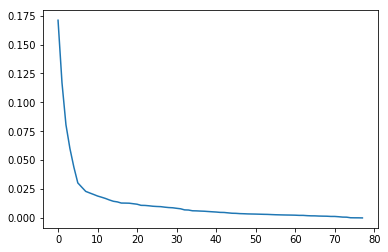

In [390]:
plt.plot(num_components)

* From the plot above it seems after about 20 PCAs the variance decrease is a much slower or gradual incremental decline opposed to looking at PCAs from 1 to about 10.

3. Re-apply PCA to the data while selecting for number of components to retain.

In [391]:
# This function was provided by Udacity Instructors: 
# code reference: https://view3854ccca.udacity-student-workspaces.com/edit/helper_functions.py
def do_pca(n_components, df):
    '''
    Transforms data using PCA to create n_components
    OUTPUT: pca - the pca object created after fitting the azdias_pca data
            azdias_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    azdias_pca = pca.fit_transform(df) # scaled df 
    return pca, azdias_pca

In [402]:
pca, azdias_pca = do_pca(20, azdias_clean_scaled)

In [403]:
num_comp = len(pca.explained_variance_ratio_) # num of comps
ind_comp = np.arange(num_comp) # each comp in an array
var_exp = pca.explained_variance_ratio_ # explained variances

In [404]:
display( num_comp, ind_comp, var_exp )

20

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

array([0.17103557, 0.116863  , 0.08063913, 0.06014196, 0.0439695 ,
       0.03030687, 0.02659861, 0.02295897, 0.02160623, 0.02030211,
       0.01893976, 0.01791804, 0.01682434, 0.01550875, 0.01437703,
       0.01383203, 0.01283283, 0.0127583 , 0.01264119, 0.01225371])

In [405]:
# This function was provided by Udacity Instructors: 
# code reference: https://view3854ccca.udacity-student-workspaces.com/edit/helper_functions.py
def scree_plot(pca, num_comp, var_exp, ind_comp):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(var_exp)
    ax.bar(ind_comp, var_exp)
    ax.plot(ind_comp, cumvals)
    for i in range(num_comp):
        ax.annotate(r"%s%%" % ((str(var_exp[i]*100)[:4])), (ind_comp[i]+0.2, var_exp[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

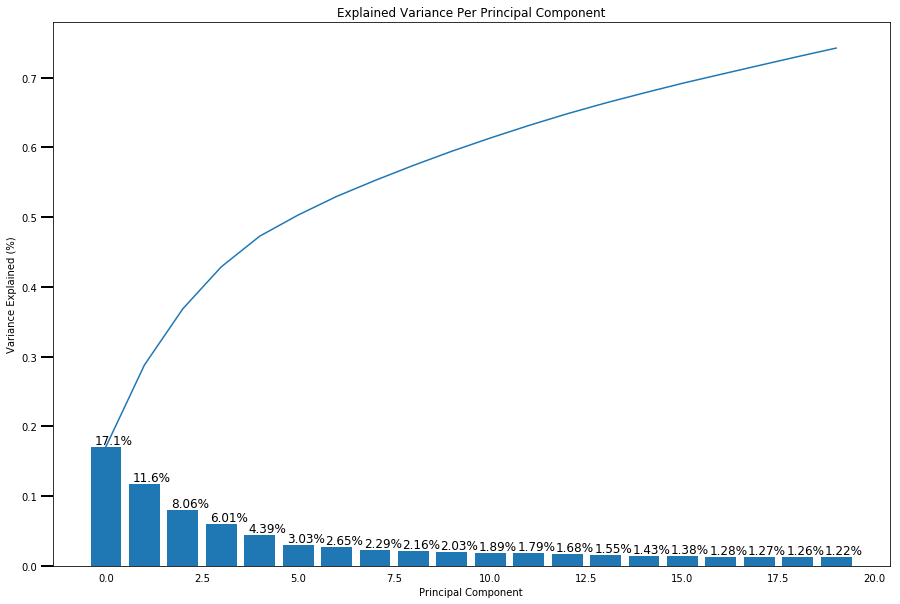

In [406]:
scree_plot(pca, num_comp, var_exp, ind_comp)

In [408]:
x = ind_comp
y = var_exp

plotly.offline.iplot({
    "data": [go.Bar(x=x, y=y )],
        "layout": go.Layout(title="Variance Accounted for by each PC")
})

### Discussion 2.2: Perform Dimensionality Reduction
_reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?_

1. I would say there's about ~6 PCs that provide the most, up to ~50% of variance. 

2. From our scree plot (_which was referenced from the Udacity instructor materials from Lesson 4 on "Dimensionality Reduction and PCA"_) which shows us that the first component's variability is about 17.1%, the second component's variability is about 11.6% and so on while the line represents the total amount of variability, which is about 90% with over 30 PCs listed in the graph.

3. I believe I will keep the first ~20 PCAs in research during this task, I learned to check if eigenvalues are larger than 1 while also considering total explained variance of the first 20 features. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

##### Reference notes from Udacity Lesson 4 on Dimensionality Reduction & PCA: 
1. The amount of variance explained by each component. This is called an **eigenvalue**.
2. PCAs are "a vector of weights" and help us understand which values of each column from `azdias` dataset, are significant in how we determine what customer segements to add to our "mail order" group. 

1. Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.

In [409]:
i = 0
x = azdias_clean.columns.values
y = pca.components_

In [410]:
def get_weight_feature_mapping(x, y, i):        
    feature_weight_map = dict(zip(x, y[i]))    
    feature_weight_ith_top = sorted(feature_weight_map.items(), key=lambda x:x[1])[-3:]
    feature_weight_ith_bottom = sorted(feature_weight_map.items(), key=lambda x:x[1])[:3]

    return feature_weight_ith_top, '\n', feature_weight_ith_bottom

In [411]:
get_weight_feature_mapping(x, y, 0)

([('PLZ8_ANTG4', 0.19231466211871898),
  ('HH_EINKOMMEN_SCORE', 0.1932665321739959),
  ('PLZ8_ANTG3', 0.19879240863382105)],
 '\n',
 [('LP_STATUS_FEIN', -0.21914798068622326),
  ('LP_STATUS_GROB', -0.21753775128820663),
  ('MOBI_REGIO', -0.20253855262363527)])

##### Top: 
1. PLZ8_ANTG4: number of 10+ family houses in PLZ28 region 0-2=high share 
2. HH_EINKOMMEN_SCORE: estimated HH income 1-6=very low 
3. PLZ8_ANTG3:  number of 6-10 family houses in PLZ28 region 0-3=high share 


##### Bottom: 
1. LP_STATUS_FEIN: social status, fine scale 1-10=top earner 
2. LP_STATUS_GROB: family type, rough scale 1-5=multi-HH
3. MOBI_REGIO: movement patterns 1-6=none

In [412]:
get_weight_feature_mapping(x, y, i=1)

([('SEMIO_ERL', 0.22314010148188115),
  ('FINANZ_VORSORGER', 0.23602107048494161),
  ('ALTERSKATEGORIE_GROB', 0.2631691973245896)],
 '\n',
 [('SEMIO_REL', -0.25547117409692677),
  ('PRAEGENDE_JUGENDJAHRE_DECADE', -0.2471933811281706),
  ('FINANZ_SPARER', -0.24576727634217016)])

##### Top: 
1. SEMIO_ERL: personality typology, 1-7=lowest affinity
2. FINANZ_VORSORGER: financial topology 1=5=very low
3. ALTERSKATEGORIE_GROB: estimated age 1=4 > 60 years

##### Bottom: 
1. SEMIO_REL: personality typology, 1-7=lowest affinity
1. PRAEGENDE_JUGENDJAHRE_DECADE:  custom categorical on decade of youth
3. FINANZ_SPARER: financial typology, 1-5=very low 

In [413]:
get_weight_feature_mapping(x, y, 2)

([('SEMIO_FAM', 0.25501507700221104),
  ('SEMIO_SOZ', 0.26048139949434695),
  ('SEMIO_VERT', 0.3368171063227514)],
 '\n',
 [('ANREDE_KZ', -0.36291609239500505),
  ('SEMIO_KAEM', -0.3315486615760117),
  ('SEMIO_DOM', -0.30689529520543424)])

##### Top: 
1. SEMIO_FAM: personality typology, 1-7=lowest affinity
2. SEMIO_SOZ:  personality typology, 1-7=lowest affinity
3. SEMIO_VERT: personality typology, 1-7=lowest affinity

##### Bottom: 
1. ANREDE_KZ: gender
2. SEMIO_KAEM: personality typology, 1-7=lowest affinity
3. SEMIO_DOM: personality typology, 1-7=lowest affinity

### Discussion 2.3: Interpret Principal Components

Reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

1. Top scores for number of family houses in PLZ28 region, estimated HH income, lower weight for that feature mapping was social status, family type which sounds like it’s not as influential to customer segmenting like how household income might be. The other groups were more on personality typologies, a few included age, and decade with financial typology as well. Interestingly, the `gender` related column was lower group which could mean gender is not as important as considering other factors that are more financial related potentially because larger incomes are coming from both male and female households.
2. I would say there are more questions to ask, and we couldn't not fully interpret this data completely given these results.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

1. Run k-means clusering, and compute the average within-cluster distances

In [414]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

In [419]:
azdias_kmeans = KMeans(n_clusters=10) 
azdias_model = azdias_kmeans.fit(azdias_pca)

In [420]:
# plot_data(azdias_clean_scaled, azdias_label)

##### Udacity Instructor Reference Tip from Lesson 1 on "Clustering": 
1. When using the **elbow method** in conjunction with the **scree plot** you can see how "the average distance will always decrease with each additional cluster center. However, with fewer clusters, those decreases will be more substantial. At some point, adding new clusters will no longer create a substantial decrease in the average distance. This point is known as the elbow."

1. Investigate the change in within-cluster distance across number of clusters.

In [421]:
# code reference has been modified: https://view1f0631c6.udacity-student-workspaces.com/edit/helpers2.py
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

def get_mods(data):
    scores = []
    centers = list(range(1,11))
    for center in centers:
        scores.append(get_kmeans_score(data, center))
    return centers, scores

In [422]:
centers, scores = get_mods(azdias_pca)

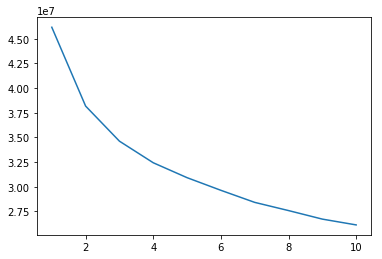

In [423]:
plt.plot(centers, scores)

1. Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data.

In [424]:
azdias_kmeans_refit = KMeans(n_clusters=8)
azdias_kmeans_refit_model = azdias_kmeans_refit.fit(azdias_pca)

In [425]:
azdias_label = azdias_kmeans_refit_model.predict(azdias_pca) 

In [426]:
azdias_label

array([3, 4, 1, ..., 4, 6, 1], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

Using the elbow method, which tells us the average distance of the center of the cluster to each point on the y axis, will always decrease with each additional cluster center. (Reference: Lesson 1 Clustering). 

It would seem that from the plot above, once we get to about 8 clusters the decrease changes are more slight. As I learned in Lesson 1 there is a point in which adding more clusters doesn’t necessarily affect the average distance, which is called the “elbow”. Here the elbow almost looks to be at 2 clusters, or 4 but, you can really see the drop off at 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

1. Apply pre-processing 

In [457]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [458]:
customer_clean = clean_data(customers) 

2. Compare column differences between azdias and customers
    * There are no customer columns not in azdias
    * There are azdias columns not in customer
    * Ensure both datasets have the same columns

In [459]:
customer_cols = customer_clean.columns
azdias_cols = azdias_clean.columns

common_cols = customer_cols.intersection(azdias_cols)
azdias_not_customer = azdias_cols.difference(customer_cols) 

In [460]:
removed_cols = azdias_not_customer.difference( common_cols )

In [461]:
combined_cols = azdias_not_customer.append( common_cols ) 

In [462]:
created_cols = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'CAMEO_INTL_2015_LIFESTAGE', 'CAMEO_INTL_2015_WEALTH', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']

In [463]:
new_combined_cols = []
for cols in combined_cols:
    if cols not in removed_cols and cols not in created_cols:
        new_combined_cols.append(cols)

In [464]:
customer_equal = customers[new_combined_cols]
azdias_equal = azdias_clean[new_combined_cols]

In [465]:
customer_equal.shape

(191652, 73)

In [466]:
azdias_equal.shape

(797426, 73)

3. Imputing

In [467]:
customer_equal_imputed = imputer.transform(customer_equal)

In [468]:
customer_equal_imputed

array([[4., 1., 5., ..., 1., 2., 1.],
       [4., 1., 6., ..., 3., 5., 3.],
       [4., 2., 2., ..., 3., 5., 3.],
       ...,
       [4., 1., 2., ..., 3., 7., 5.],
       [3., 2., 4., ..., 3., 4., 4.],
       [2., 1., 2., ..., 1., 3., 1.]])

4. Scaling

In [469]:
customers_scaled = scaler.fit_transform(customer_equal_imputed)

In [470]:
customers_scaled

array([[ 0.88663688, -0.77696529,  0.70377106, ..., -2.15033449,
        -1.66569659, -1.57741617],
       [ 0.88663688, -0.77696529,  1.25224527, ...,  0.14916922,
        -0.04748888,  0.061867  ],
       [ 0.88663688,  1.28705878, -0.94165156, ...,  0.14916922,
        -0.04748888,  0.061867  ],
       ...,
       [ 0.88663688, -0.77696529, -0.94165156, ...,  0.14916922,
         1.03131625,  1.70115018],
       [-0.05125179,  1.28705878,  0.15529685, ...,  0.14916922,
        -0.58689145,  0.88150859],
       [-0.98914046, -0.77696529, -0.94165156, ..., -2.15033449,
        -1.12629402, -1.57741617]])

5. Apply PCA 
    * We'll use 20 components as that's what we decided on our final PCA analysis for the demographics data

In [471]:
customers_pca = pca.transform(customers_scaled)

4. Apply KMeans and get predictions for customer data

In [515]:
customers_label = azdias_kmeans_refit_model.predict(customers_pca)

In [516]:
customers_label

array([7, 6, 2, ..., 1, 5, 7], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

1. Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

In [517]:
# code reference: https://knowledge.udacity.com/questions/124964
azdias_data = pd.Series(azdias_label).value_counts().rename('general_population', inplace=True)

In [518]:
customers_data = pd.Series(customers_label).value_counts().rename('customers', inplace=True)

In [519]:
azdias_data.shape, customers_data.shape

((8,), (8,))

In [520]:
pd.DataFrame([azdias_data, customers_data])

,0,1,2,3,4,5,6,7
general_population,101762,102043,123383,86897,95844,111004,87760,88733
customers,4735,34313,21691,47284,29513,17163,4120,32833


In [521]:
combined_data = pd.DataFrame([azdias_data, customers_data])

In [560]:
azdias_df = pd.DataFrame(azdias_data).reset_index().rename(columns={'index':'cluster'})
customers_df = pd.DataFrame(customers_data).reset_index().rename(columns={'index':'cluster'})
display(azdias_df.head(), customers_df.head())

,cluster,general_population
0,2,123383
1,5,111004
2,1,102043
3,0,101762
4,4,95844


,cluster,customers
0,3,47284
1,1,34313
2,7,32833
3,4,29513
4,2,21691


In [574]:
diff_df = pd.merge(azdias_df, customers_df, on='cluster')                 
diff_df['diff'] = (abs( diff_df['general_population'] - diff_df['customers'])/ (diff_df['general_population'] + diff_df['customers']) )   
diff_df

,cluster,general_population,customers,diff
0,2,123383,21691,0.70097
1,5,111004,17163,0.73218
2,1,102043,34313,0.49671
3,0,101762,4735,0.91108
4,4,95844,29513,0.52914
5,7,88733,32833,0.45983
6,6,87760,4120,0.91032
7,3,86897,47284,0.29522


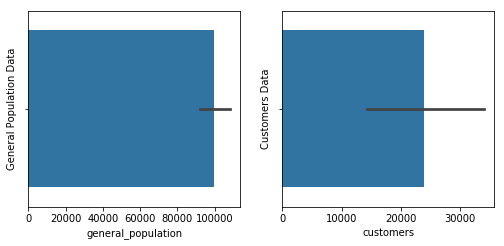

In [524]:
# plt.bar(cust.value_counts().index, cust.value_counts() / cust.value_counts().sum())   

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(left=1, bottom=1, right=2, top=2)

fig.add_subplot(231)
sns.barplot(data=azdias_data, x=azdias_data.index)
plt.ylabel('General Population Data')

fig.add_subplot(2, 3, 2)
sns.barplot(data=customers_data, x=customers_data.index)
plt.ylabel('Customers Data')

plt.show()

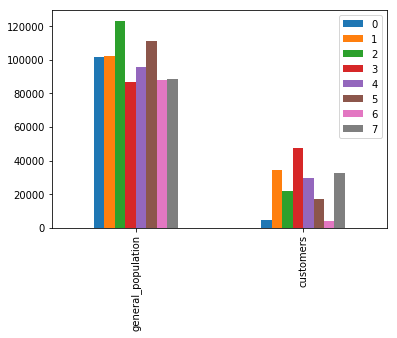

In [525]:
combined_data.plot(kind='bar')

In [542]:
azdias_kmeans_refit_model.cluster_centers_[0:3][0:3]

array([[ 2.69405131,  1.8383845 ,  2.83980598,  0.19361641,  0.53228115,
         0.18826194, -0.12078363, -0.08785452,  0.03141464,  0.17840041,
        -0.34143286, -0.18622943, -0.3325691 ,  0.08676238,  0.1769008 ,
        -0.15048682, -0.11930704,  0.05487329,  0.24550782, -0.01708082],
       [-2.84641531,  0.46881148,  2.27300457, -1.75616476, -0.6901375 ,
        -0.31500565,  0.03782348, -0.2148872 , -0.03409889,  0.17572774,
        -0.13840924, -0.09271952, -0.01693866,  0.02299475,  0.02581456,
        -0.0055573 , -0.01477154,  0.04020407, -0.05971726,  0.05165915],
       [-3.75986842,  1.87222499, -1.95366051,  0.28160389, -0.23681803,
        -0.28116173,  0.11260573, -0.12009795, -0.04063608, -0.08201081,
        -0.08373327,  0.073118  ,  0.215004  , -0.0437849 ,  0.01628696,
        -0.05077603,  0.0625381 , -0.08709087,  0.0513046 ,  0.09957206]])

In [547]:
azdias_kmeans_refit_model.labels_[0:3][0:3]

array([3, 4, 1], dtype=int32)

In [555]:
pd.options.display.float_format = '{:,.5f}'.format
kmeans_cluster_centers = pd.DataFrame(azdias_kmeans_refit_model.cluster_centers_[0:3,0:3], 
                                     azdias_kmeans_refit_model.labels_[0:3][0:3])
kmeans_cluster_centers

,0,1,2
3,2.69405,1.83838,2.83981
4,-2.84642,0.46881,2.27300
1,-3.75987,1.87222,-1.95366


### Review Clusters from Refitted KMeans Model:

#### Cluster 3:
Looking at our cluster centers from our KMeans refitted model using 8 clusters, we can see cluster 3 had positive values across all 5 PCAs while I've only selected visually the first 3. This cluster contained positive values for gender, estimated age based on a name analysis, and customer journey topology. This means, gender was more female, age were closer to or within 30 years old, and customers tended to prefer advertising and were consumption traditionlists. 

1. ANREDE_KZ
2. ALTERSKATEGORIE_GROB
3. CJT_GESAMTTYP

#### Cluster 4: 

Cluster 4 included values from cluster 3, and included a negative value in the first PCA. This means, gender was more unknown, age were unknown or missing, and customers tended to prefer advertising and were consumption traditionlists. 

1. ALTERSKATEGORIE_GROB 
2. ANREDE_KZ
3. CJT_GESAMTTYP

#### Cluster 1:

Cluster 1 included values from cluster 3, age was unknown or missing, gender here seemed to be male, and customers was potentially unknown.

### Review PCA Feature Weights:

Let's check the `get_weight_feature_mapping` we did earlier in the PCA analysis to look at actual weight to feature columns and assess the types of features that received top weights vs. bottom weights.

In [551]:
i = 0
x = azdias_clean.columns.values
y = azdias_kmeans_refit_model.cluster_centers_

In [556]:
get_weight_feature_mapping(x, y, 0)

([('ANREDE_KZ', 1.8383845045856586),
  ('ALTERSKATEGORIE_GROB', 2.6940513062555844),
  ('CJT_GESAMTTYP', 2.839805978396657)],
 '\n',
 [('GFK_URLAUBERTYP', -0.3414328638188895),
  ('HEALTH_TYP', -0.33256910324502775),
  ('GREEN_AVANTGARDE', -0.18622942905911777)])

In [557]:
get_weight_feature_mapping(x, y, 1)

([('FINANZTYP', 0.17572773781567),
  ('ANREDE_KZ', 0.4688114815380625),
  ('CJT_GESAMTTYP', 2.2730045737570714)],
 '\n',
 [('ALTERSKATEGORIE_GROB', -2.8464153136732095),
  ('FINANZ_MINIMALIST', -1.7561647550946988),
  ('FINANZ_SPARER', -0.6901374978971698)])

In [558]:
get_weight_feature_mapping(x, y, 2)

([('HEALTH_TYP', 0.21500399876579257),
  ('FINANZ_MINIMALIST', 0.2816038913249695),
  ('ANREDE_KZ', 1.872224987056072)],
 '\n',
 [('ALTERSKATEGORIE_GROB', -3.759868418410784),
  ('CJT_GESAMTTYP', -1.9536605081969904),
  ('FINANZ_VORSORGER', -0.28116172831168296)])

In [ ]:
Bottom Weights Descriptions: 
- ALTERSKATEGORIE_GROB: estimated age, 
- CJT_GESAMTTYP: customer journey typology
- FINANZ_VORSORGER: financial typology

1. What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

The overrepresented people were a mix of male and female, in the 30 age range, and preferred advertising and were most likely consumption traditionalists. However, clusters 4 and 1 had more missing or unknown values. It seems person level features was highest descriptor of customer behavior here. 

2. What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

The most underrepresented people were financial high and low earners, the features labeled with prefix “FINANZ_” were more times present in the bottom weights feature mapping results than in the top. Also, “ALTERSKATEGORIE_GROB” was another feature which appeared mostly in first few clusters however, had poor coverage which means, likely, another survey or change in how they receive this data could help with. 

### Discussion 3.3: Compare Customer Data to Demographics Data

When comparing the two datasets, it seems cluster 1 was high in both in addition to cluster 7. Clusters 3 and 4 were similarly represented.  As the instructions suggest, if we consider the customer base as universal, then the proportions between the two datasets should be similar. This was not the case. Clusters 0 and 6 had the highest differences in representation while cluster 2 and 5 were second. This indicates as our instructions suggest, there may be only particular segments of the population that are interested in the company’s products. 

In conclusion, given that cluster 0 and 6 had the lowest representation in the customer dataset that may infer these persons are outside the target demographics. While conversely, the highest proportion of customers came from cluster 3 which was not as highly represented in the general population and may suggest the company to look at this particular type of consumer.